## **Set up**

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import csv
import os

from google.colab.patches import cv2_imshow

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

100% 1.82G/1.82G [00:18<00:00, 85.9MB/s]
100% 1.82G/1.82G [00:18<00:00, 107MB/s] 


In [ ]:
!unzip stanford-cars-dataset

## **Predefined functions:**

*format_images:* 
*   takes in a list of image file paths
*   normalize and resize images
*   Records shape of original image for normalized outputs
*   Returns processed images and original sizes 

*get_bboxes:*
*   Parses through annotation csv file to obtain labels (bounding box values)
*   bounding box = [x1, y1, x2, y2], where x1, y1 define top left corner, and x2, y2 define bottom right corner

*normalize_bboxes:*
*   Takes in list of original image sizes, along with bounding box values
*   Normalizes bounding box values to a scale of [0,1]










In [ ]:
IMAGE_SIZE = 64
def format_images(image_paths):
  image_set = []
  sizes = []
  for i in range(len(image_paths)):
    if i % 1000 == 0:
      print(i)
    imagePath = image_paths[i]
	  # load the image, resize the image to be 512x512 pixels,
    # and add resulting np array to list
    image = cv2.imread(imagePath)
    image = image/255.0
    sizes.append([image.shape[0], image.shape[1]])
    image = cv2.resize(image, (64, 64))
    image_set.append(image)
  return np.asarray(image_set), sizes

def get_bboxes(annos_file):
  bboxes = []
  with open(annos_file) as csvfile:
    reader = csv.reader(csvfile) # change contents to floats
    next(reader)
    count = 0
    idx = 0
    for row in reader:
      if count % 3 == 0:
        bboxes.append([int(row[0]), int(row[1]), int(row[2]), int(row[3])])
      count += 1
  return np.asarray(bboxes)
      
def normalize_bboxes(sizes, bboxes):
  normalized = []
  for idx in range(len(bboxes)):
    bbox = bboxes[idx]
    img_w = sizes[idx][0]
    img_h = sizes[idx][1]
    normalized.append([bbox[0]/img_h, bbox[1]/img_w, bbox[2]/img_h, bbox[3]/img_w])
  return np.asarray(normalized)

## **Preprocess Data**

Define training/validation split (8144 total images in training data)\\

Get image path files, preprocess image data, and store in appropriate variables

In [ ]:
train_val_split = 7000

#Get a list of paths leading to training and testing image directories
train_imagePaths = sorted(list(paths.list_images("cars_train/")))[:train_val_split]
val_imagePaths = sorted(list(paths.list_images("cars_train/")))[train_val_split:]
test_imagePaths = sorted(list(paths.list_images("cars_test/")))

#Convert images to uniform size numpy arrays
train_images, train_sizes = format_images(train_imagePaths)
val_images, val_sizes = format_images(val_imagePaths)
test_images, test_sizes = format_images(test_imagePaths)

In [ ]:
print(train_bboxes_orig[0], train_bboxes_norm[0], train_sizes[0])

Extract and normalize bounding box values for training and evaluation

In [ ]:
#Get bounding boxes (Labels) for train, val, and test images
bboxes = get_bboxes("cars_train_annos.csv")
train_bboxes_orig = bboxes[:train_val_split]
train_bboxes_norm = normalize_bboxes(train_sizes, train_bboxes_orig)
val_bboxes_orig = bboxes[train_val_split:]
val_bboxes_norm = normalize_bboxes(val_sizes, val_bboxes_orig)
test_bboxes_orig = get_bboxes("cars_test_annos.csv")
test_bboxes_norm = normalize_bboxes(test_sizes, test_bboxes_orig)

Testing bounding box normalization for correct conversion

In [ ]:
image = cv2.imread(train_imagePaths[0])
image2 = image.copy()
bbox = train_bboxes_orig[0]
start = (bbox[0], bbox[1])
end = (bbox[2], bbox[3])
cv2.rectangle(image2, pt1=(bbox[0], bbox[1]), pt2=(bbox[2], bbox[3]), color=(255,0,0), thickness = 2)
cv2_imshow(image2)

In [ ]:
image3 = train_images[0]
image4 = image3.copy()
bbox = train_bboxes_norm[0]
start = (int(bbox[0]*IMAGE_SIZE), int(bbox[1]*IMAGE_SIZE))
end = (int(bbox[2]*IMAGE_SIZE), int(IMAGE_SIZE*bbox[3]))
print(start, end)
cv2.rectangle(image4, pt1=start, pt2=end, color=(0,255,255), thickness = 2)
plt.imshow(train_images[0])

## **Defining Model**
Define base model: MobileNet V2 (not trainable)

In [ ]:
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

Add Dense layers on top of base model. These layers will be trained ro predict bounding box values

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(64, activation = 'relu'),
  tf.keras.layers.Dense(32, activation = 'relu'),
  tf.keras.layers.Dense(4, activation = 'sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 2,342,180
Trainable params: 84,196
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.mean_squared_error,
              metrics=tf.keras.metrics.MAE)

In [ ]:
history = model.fit(train_images, train_bboxes_norm,
                    epochs=5,
                    batch_size = 100,
                    validation_data=(val_images, val_bboxes_norm), verbose = 1)

Epoch 1/5
70/70 [==============================] - 23s 324ms/step - loss: 0.0045 - mean_absolute_error: 0.0506 - val_loss: 0.0052 - val_mean_absolute_error: 0.0531
Epoch 2/5
70/70 [==============================] - 23s 324ms/step - loss: 0.0040 - mean_absolute_error: 0.0476 - val_loss: 0.0054 - val_mean_absolute_error: 0.0542
Epoch 3/5
70/70 [==============================] - 23s 328ms/step - loss: 0.0037 - mean_absolute_error: 0.0456 - val_loss: 0.0053 - val_mean_absolute_error: 0.0538
Epoch 4/5
70/70 [==============================] - 23s 329ms/step - loss: 0.0033 - mean_absolute_error: 0.0434 - val_loss: 0.0057 - val_mean_absolute_error: 0.0563
Epoch 5/5
70/70 [==============================] - 23s 324ms/step - loss: 0.0030 - mean_absolute_error: 0.0414 - val_loss: 0.0057 - val_mean_absolute_error: 0.0550


## **Make predictions on test set and visualize results**

In [ ]:
preds = model.predict(test_images[:100])

In [ ]:
print(preds)

Testing on random sample from testing set

(1000, 1333, 3) [1000, 1333]


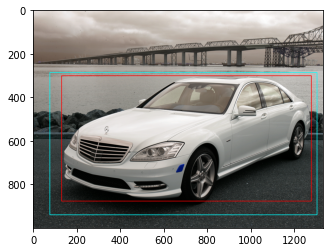

In [ ]:
index = 24
pred = preds[index]
# img = test_images[index].copy()
original = cv2.imread(test_imagePaths[index])
image = original.copy()
width = test_sizes[index][0]
height = test_sizes[index][1]
print(image.shape, test_sizes[index])

start = (int(pred[0]*height), int(pred[1]*width))
end = (int(pred[2]*height), int(pred[3]*width))
label_start = (test_bboxes_orig[index][0], test_bboxes_orig[index][1])
label_end = (test_bboxes_orig[index][2], test_bboxes_orig[index][3])

cv2.rectangle(image, start, end, (0, 255, 255), 2)
cv2.rectangle(image, label_start, label_end, (255, 0, 0), 2)
plt.imshow(image)